In [ ]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep_new_v2 import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['legend.fontsize']=11

fig_width = 6
fig_width_big = 12

In [10]:

current_path = os.getcwd().split("in-context-bldc")[0]
data_path = os.path.join(current_path,"in-context-bldc", "data")

folder = "CL_experiments_double_sensor_low_speed_ekf_and_meta/final"
folder_path = os.path.join(data_path, folder)


In [11]:
list_of_folders = glob.glob(os.path.join(folder_path, '*'))[:6]
print(list_of_folders)
identifiers = [list_of_folders[i].split("_")[-2][-9:] for i in range(len(list_of_folders))]
print(identifiers)

#### inertias [e-4]: I5 = 0.7, I15 = 3.1, I9 = 5.8, I11 = 6.8, I7 = 8.8
order = [0, 5, 2, 3, 1]
list_of_folders = [list_of_folders[j] for j in order]
identifiers = [identifiers[j] for j in order]
print(list_of_folders)
print(identifiers)

['c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia05_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia07_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia09_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia11_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia13_ki-0.0029-kp-3.0000', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\\inertia15_ki-0.0029-kp-3.0000']
['inertia05', 'inertia07', 'inertia09', 'inertia11', 'inertia13', 'inertia15']
['c:\\Us

In [12]:

rmse_list_meta = []
rmse_list_ekf = []

for exp_idx in range(len(list_of_folders)):
    rmse_config_meta = []
    rmse_config_ekf = []
    exp_path = list_of_folders[exp_idx]
    csv_list = glob.glob(os.path.join(exp_path, "*.csv"))
    for file in csv_list:

        df = pd.read_csv(file)
        rmse_config_meta.append(   np.sqrt(  (   (   df["omega"].to_numpy()-df["omega_meta"].to_numpy()   )**2    ).mean()   )   )
        rmse_config_ekf.append(    np.sqrt(  (   (   df["omega"].to_numpy()-df["omega_ekf"].to_numpy()    )**2    ).mean()   )   )

    rmse_list_meta.append(rmse_config_meta)
    rmse_list_ekf.append(rmse_config_ekf)

# print(rmse_list_meta)


dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
['_set_edgecolor', '_set_facecolor', 'set_color', 'set_edgecolor', 'set_facecolor']


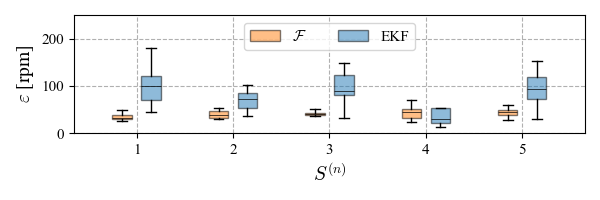

In [13]:

rmse_full_meta = np.column_stack(rmse_list_meta)
rmse_full_ekf = np.column_stack(rmse_list_ekf)
dx = 0.15
width = 0.2
# print(rmse_full.shape)

flierprops_meta = dict(marker='', markerfacecolor='tab:orange', markersize=4,
                  linestyle='none', markeredgecolor='none')
flierprops_ekf = dict(marker='', markerfacecolor='tab:blue', markersize=4,
                  linestyle='none', markeredgecolor='none')

fig = plt.figure(figsize=(6,2))
b_plot_meta = plt.boxplot(rmse_full_meta, positions=np.arange(5)+1-dx, widths=width, patch_artist=True, flierprops=flierprops_meta, label = r"$\mathcal{F}$")
b_plot_ekf= plt.boxplot(rmse_full_ekf, positions=np.arange(5)+1+dx, widths=width, patch_artist=True, flierprops=flierprops_ekf, label = r"EKF")

print(b_plot_ekf.keys())

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(b_plot_meta[element], color="black")
        plt.setp(b_plot_ekf[element], color="black")
for patch in b_plot_meta['boxes']:
    patch.set_facecolor("tab:orange")
    patch.set_edgecolor("black")
    patch.set_alpha(0.5)
for patch in b_plot_ekf['boxes']:
    patch.set_facecolor("tab:blue")
    patch.set_edgecolor("black")
    patch.set_alpha(0.5)

plt.setp(b_plot_meta["medians"], linewidth = 0.5)
plt.setp(b_plot_ekf["medians"], linewidth = 0.5)



print([method_name for method_name in dir(patch) if callable(getattr(patch, method_name)) and ("color" in method_name) and ("set" in method_name)])
x_tick_labels = [str(i + 1)  for i in range(len(list_of_folders))] 
plt.xticks(np.arange(5)+1, x_tick_labels)
plt.ylabel(r"$\varepsilon$ [rpm]")
plt.xlabel("$S^{(n)}$")
fig.tight_layout()
plt.legend(ncols=2)
plt.ylim([0,250])
plt.tight_layout()
# plt.savefig("figures\\boxplot_5.pdf", dpi=300)
plt.show()


In [14]:

# for i in range(10):

#     y_full_np = y_full_all.cpu().numpy()  # Shape (seq_len, 1)
#     y_pred_np = y_pred_all.cpu().numpy()
#     # print(y_full_np.shape)
#     plt.figure(figsize=(10,4))
#     plt.plot(y_full_np[i])
#     plt.plot(y_pred_np[i])
#     plt.show()

#     # plt.figure(figsize=(10,4))
#     # plt.plot(y_full_np[i]/y_pred_np[i])
    
#     plt.show()
    